In [1]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285388 sha256=438629eff9fe0404a0b6f1d6e9a836b3245a787fb6e6eb31ba708d3459a20f06
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize Spark session
spark = SparkSession.builder.appName("StockPrediction").getOrCreate()

# List of dataset filenames
dataset_filenames = ["2008_Globla_Markets_Data.csv", "2009_Globla_Markets_Data.csv", "2010_Global_Markets_Data.csv", "2011_Global_Markets_Data.csv", "2012_Global_Markets_Data.csv", "2013_Global_Markets_Data.csv", "2014_Global_Markets_Data.csv", "2015_Global_Markets_Data.csv", "2016_Global_Markets_Data.csv", "2017_Global_Markets_Data.csv", "2018_Global_Markets_Data.csv", "2019_Global_Markets_Data.csv", "2020_Global_Markets_Data.csv", "2021_Global_Markets_Data.csv", "2022_Global_Markets_Data.csv", "2023_Global_Markets_Data.csv"]

# Load and process each dataset
all_predictions = []
for filename in dataset_filenames:
    data = spark.read.csv(filename, header=True, inferSchema=True)

    # Data preprocessing and feature engineering
    feature_columns = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
    vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    data = vector_assembler.transform(data)

    # Split the data into training and test sets
    train_data, test_data = data.randomSplit([0.8, 0.2], seed=123)

    # Define the model (Random Forest Regressor)
    rf_model = RandomForestRegressor(featuresCol="features", labelCol="Close")

    # Train the model
    model = rf_model.fit(train_data)

    # Make predictions on the test set
    predictions = model.transform(test_data)

    all_predictions.append(predictions)

# Combine predictions from all datasets
combined_predictions = all_predictions[0]
for prediction_df in all_predictions[1:]:
    combined_predictions = combined_predictions.union(prediction_df)

# Model evaluation
evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(combined_predictions)
print(f"Combined Root Mean Squared Error (RMSE): {rmse}")
# Stop the Spark session
#spark.stop()

Combined Root Mean Squared Error (RMSE): 410.92918218392265


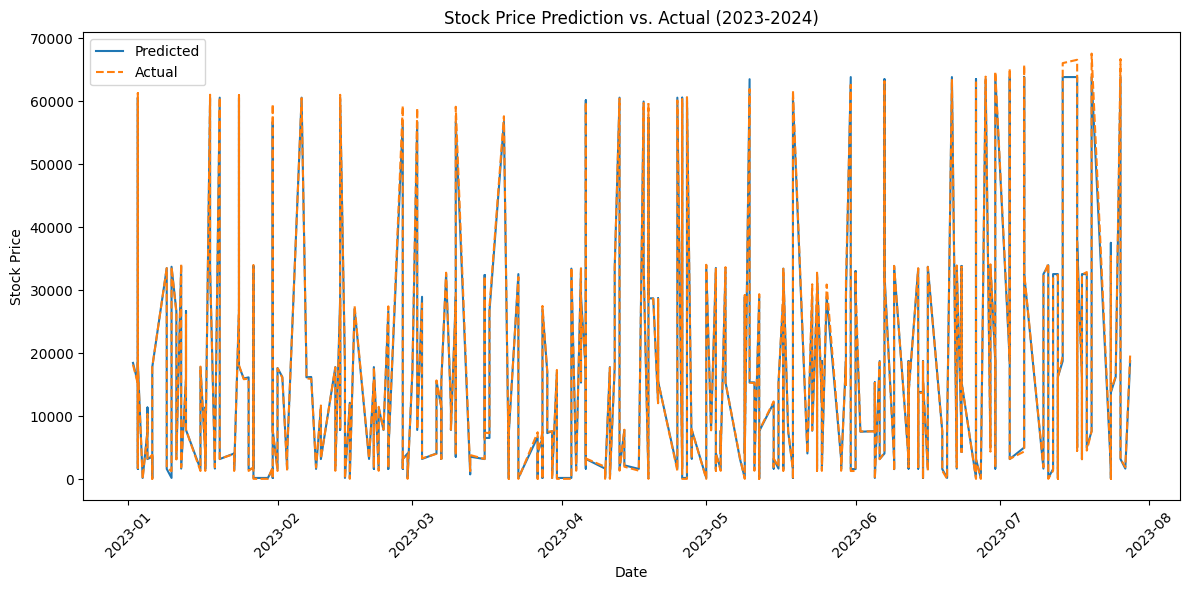

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrame to Pandas DataFrame
combined_predictions_pandas = combined_predictions.select("Date", "Ticker", "Close", "prediction").toPandas()

# Filter and sort the Pandas DataFrame by date
combined_predictions_pandas["Date"] = pd.to_datetime(combined_predictions_pandas["Date"])
combined_predictions_pandas = combined_predictions_pandas[
    (combined_predictions_pandas["Date"].dt.year >= 2023) & (combined_predictions_pandas["Date"].dt.year <= 2024)
]
combined_predictions_pandas = combined_predictions_pandas.sort_values("Date")

# Plotting predictions and actual values
plt.figure(figsize=(12, 6))
plt.plot(combined_predictions_pandas["Date"], combined_predictions_pandas["prediction"], label="Predicted")
plt.plot(combined_predictions_pandas["Date"], combined_predictions_pandas["Close"], label="Actual", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction vs. Actual (2023-2024)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Stop the Spark session
#spark.stop()


In [4]:
# Export combined predictions and actual values to a CSV file
combined_predictions_pandas.to_csv("combined_predictions_actuals.csv", index=False)


In [5]:
# Stop the Spark session
spark.stop()